In [66]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Archive:  Plant-AI-Doctor.zip
replace Plant-AI-Doctor/data/images/real/chemical/20210617_132933-1152x1536.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [67]:
!unzip Plant-AI-Doctor.zip

Archive:  Plant-AI-Doctor.zip
replace Plant-AI-Doctor/data/images/real/chemical/20210617_132933-1152x1536.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [68]:
!ls

Plant-AI-Doctor  Plant-AI-Doctor.zip  sample_data


In [69]:
!ls Plant-AI-Doctor



data


In [70]:
!ls data


ls: cannot access 'data': No such file or directory


In [71]:
!ls Plant-AI-Doctor/data

images	splits


In [72]:
!ls Plant-AI-Doctor/data/images


real


In [73]:
!ls Plant-AI-Doctor/data/images/real


chemical  disease


In [74]:
from pathlib import Path

BASE = Path("Plant-AI-Doctor/data/images/real")
chem_dir = BASE / "chemical"
dis_dir  = BASE / "disease"

print("BASE exists:", BASE.exists())
print("chemical exists:", chem_dir.exists())
print("disease exists:", dis_dir.exists())

print("chemical count:", len(list(chem_dir.iterdir())))
print("disease count:", len(list(dis_dir.iterdir())))


BASE exists: True
chemical exists: True
disease exists: True
chemical count: 67
disease count: 90


In [75]:
import pandas as pd

def list_images(folder: Path):
    exts = {".jpg", ".jpeg", ".png", ".webp"}
    return [p for p in folder.iterdir() if p.suffix.lower() in exts]

rows = []

for p in list_images(chem_dir):
    rows.append({"filepath": str(p), "label": "chemical", "source": "real"})

for p in list_images(dis_dir):
    rows.append({"filepath": str(p), "label": "biological", "source": "real"})

df = pd.DataFrame(rows)

print("Total:", len(df))
print(df["label"].value_counts())
df.head(5)


Total: 157
label
biological    90
chemical      67
Name: count, dtype: int64


,filepath,label,source
0,Plant-AI-Doctor/data/images/real/chemical/toma...,chemical,real
1,Plant-AI-Doctor/data/images/real/chemical/toma...,chemical,real
2,Plant-AI-Doctor/data/images/real/chemical/Figu...,chemical,real
3,Plant-AI-Doctor/data/images/real/chemical/צילו...,chemical,real
4,Plant-AI-Doctor/data/images/real/chemical/yell...,chemical,real


In [76]:
import numpy as np

def split_group(df_class, train=0.7, val=0.15):
    df_class = df_class.sample(frac=1, random_state=42)  # ערבוב
    n = len(df_class)

    train_end = int(n * train)
    val_end = int(n * (train + val))

    splits = (
        ["train"] * train_end +
        ["val"] * (val_end - train_end) +
        ["test"] * (n - val_end)
    )

    df_class = df_class.copy()
    df_class["split"] = splits
    return df_class

df = df.groupby("label", group_keys=False).apply(split_group)

df["split"].value_counts(), df.groupby(["label", "split"]).size()


/tmp/ipython-input-1244401784.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("label", group_keys=False).apply(split_group)


(split
 train    108
 test      25
 val       24
 Name: count, dtype: int64,
 label       split
 biological  test     14
             train    62
             val      14
 chemical    test     11
             train    46
             val      10
 dtype: int64)

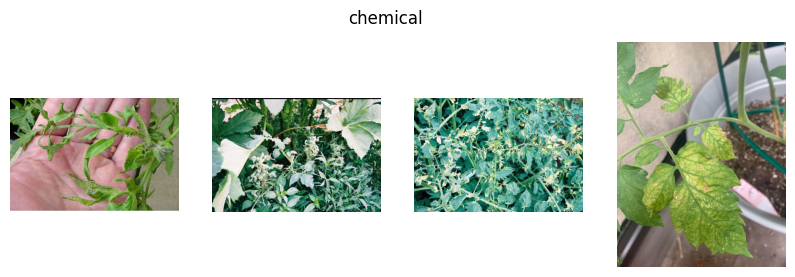

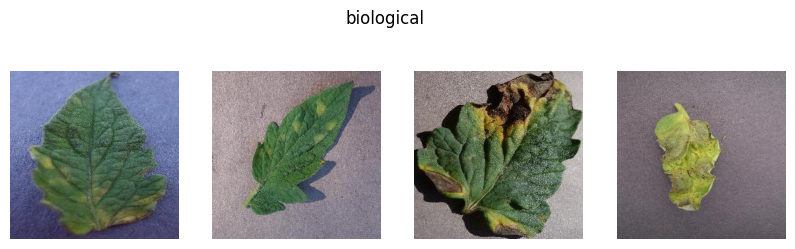

In [77]:
from PIL import Image
import matplotlib.pyplot as plt
import random

def show_samples(df, label, n=4):
    samples = df[df["label"] == label].sample(n)
    plt.figure(figsize=(10, 3))
    for i, row in enumerate(samples.itertuples()):
        img = Image.open(row.filepath)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(label)
    plt.show()

show_samples(df, "chemical")
show_samples(df, "biological")

In [78]:
from torchvision import transforms

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


In [79]:
from torch.utils.data import Dataset
from PIL import Image
import torch


In [80]:

class LeafDataset(Dataset):
    def __init__(self, df, split, transform=None):
        self.df = df[df["split"] == split].reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row.filepath).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        label = 1 if row.label == "chemical" else 0
        return image, label


In [81]:
from torch.utils.data import DataLoader

In [82]:
train_dataset = LeafDataset(df, split="train", transform=image_transform)
val_dataset   = LeafDataset(df, split="val", transform=image_transform)
test_dataset  = LeafDataset(df, split="test", transform=image_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [83]:
import torch
import torch.nn as nn
from torchvision import models

model = models.resnet18(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [84]:
model.fc = nn.Linear(model.fc.in_features, 2)

In [85]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("Using device:", device)

Using device: cpu


In [86]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [87]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)

In [88]:
num_epochs = 5

for epoch in range(num_epochs):
    train_loss = train_one_epoch(
        model,
        train_loader,
        criterion,
        optimizer,
        device
    )
    print(f"Epoch {epoch+1}/{num_epochs} | Train loss: {train_loss:.4f}")

Epoch 1/5 | Train loss: 0.2902
Epoch 2/5 | Train loss: 0.0148
Epoch 3/5 | Train loss: 0.0389
Epoch 4/5 | Train loss: 0.0067
Epoch 5/5 | Train loss: 0.0040


In [89]:
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

In [90]:
val_acc = evaluate(model, val_loader, device)
print(f"Validation accuracy: {val_acc:.3f}")

Validation accuracy: 1.000


In [91]:
len(val_dataset)

24

In [92]:
train_paths = set(train_dataset.df.filepath)
val_paths   = set(val_dataset.df.filepath)

len(train_paths.intersection(val_paths))

0

In [93]:
test_acc = evaluate(model, test_loader, device)
print(f"Test accuracy: {test_acc:.3f}")

Test accuracy: 1.000
